This Notebook improves the best BaseLine #1 with OutLiers filtration

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

In [57]:
train = pd.read_csv("./dataset/train.csv")
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [58]:
train.shape

(1460, 81)

# Remove Categorical Data

In [59]:
numerical_train = train.select_dtypes(exclude="object")
numerical_train.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


In [60]:
numerical_train.shape

(1460, 38)

# Missing Values

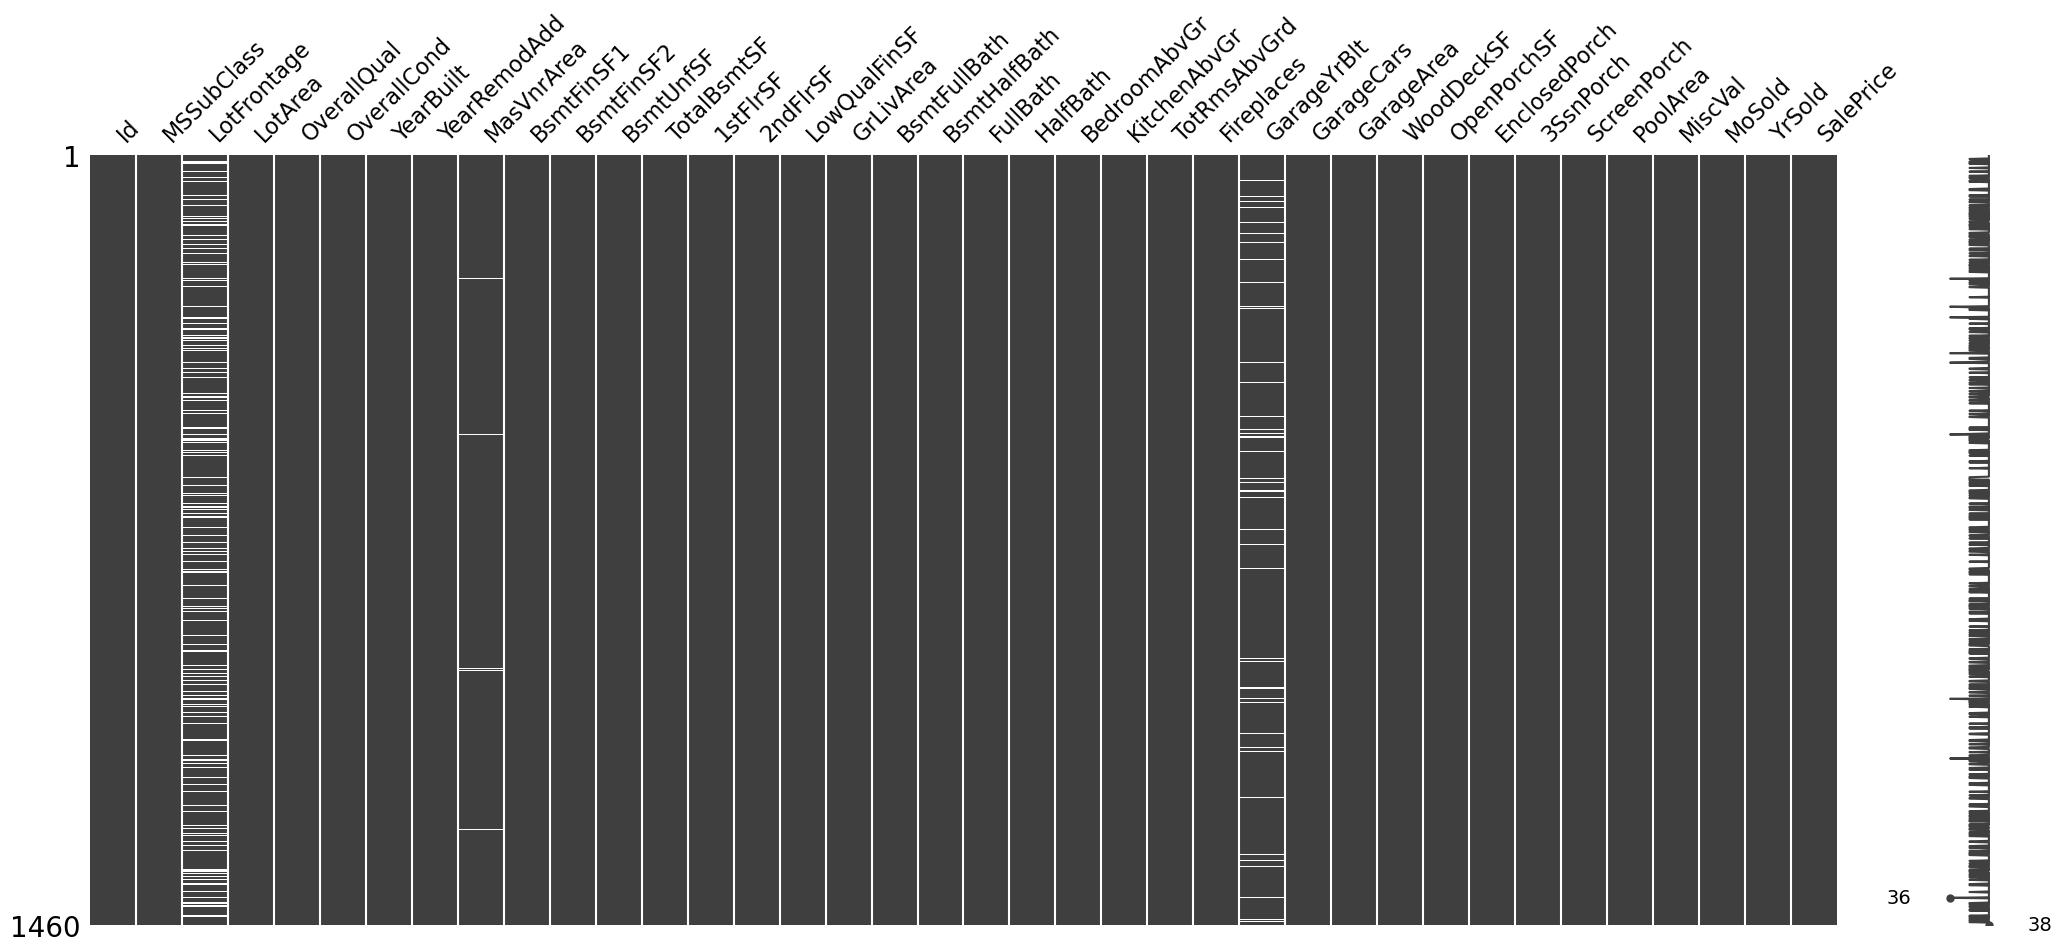

In [61]:
import missingno as msno

msno.matrix(numerical_train);

In [62]:
def missing_percentage(df):
    """This function takes a DataFrame(df) as input and returns two columns, total missing values and total missing values percentage"""
    # Get Missing Velues per feature (exclude features that are complete)
    feature_missing = df.isnull().sum().sort_values(ascending = False)
    feature_missing = feature_missing[feature_missing > 0]
    percent = round(feature_missing/len(df)*100, 2)
    return pd.concat([feature_missing, percent], axis=1, keys=['Total','Percent'])

missing_percentage(numerical_train)

,Total,Percent
LotFrontage,259,17.74
GarageYrBlt,81,5.55
MasVnrArea,8,0.55


In [63]:
numerical_train.drop(["LotFrontage"], axis=1, inplace=True)

In [64]:
missing_percentage(numerical_train)

,Total,Percent
GarageYrBlt,81,5.55
MasVnrArea,8,0.55


In [65]:
means_to_fill = numerical_train.mean()
numerical_train.fillna(means_to_fill, inplace = True)

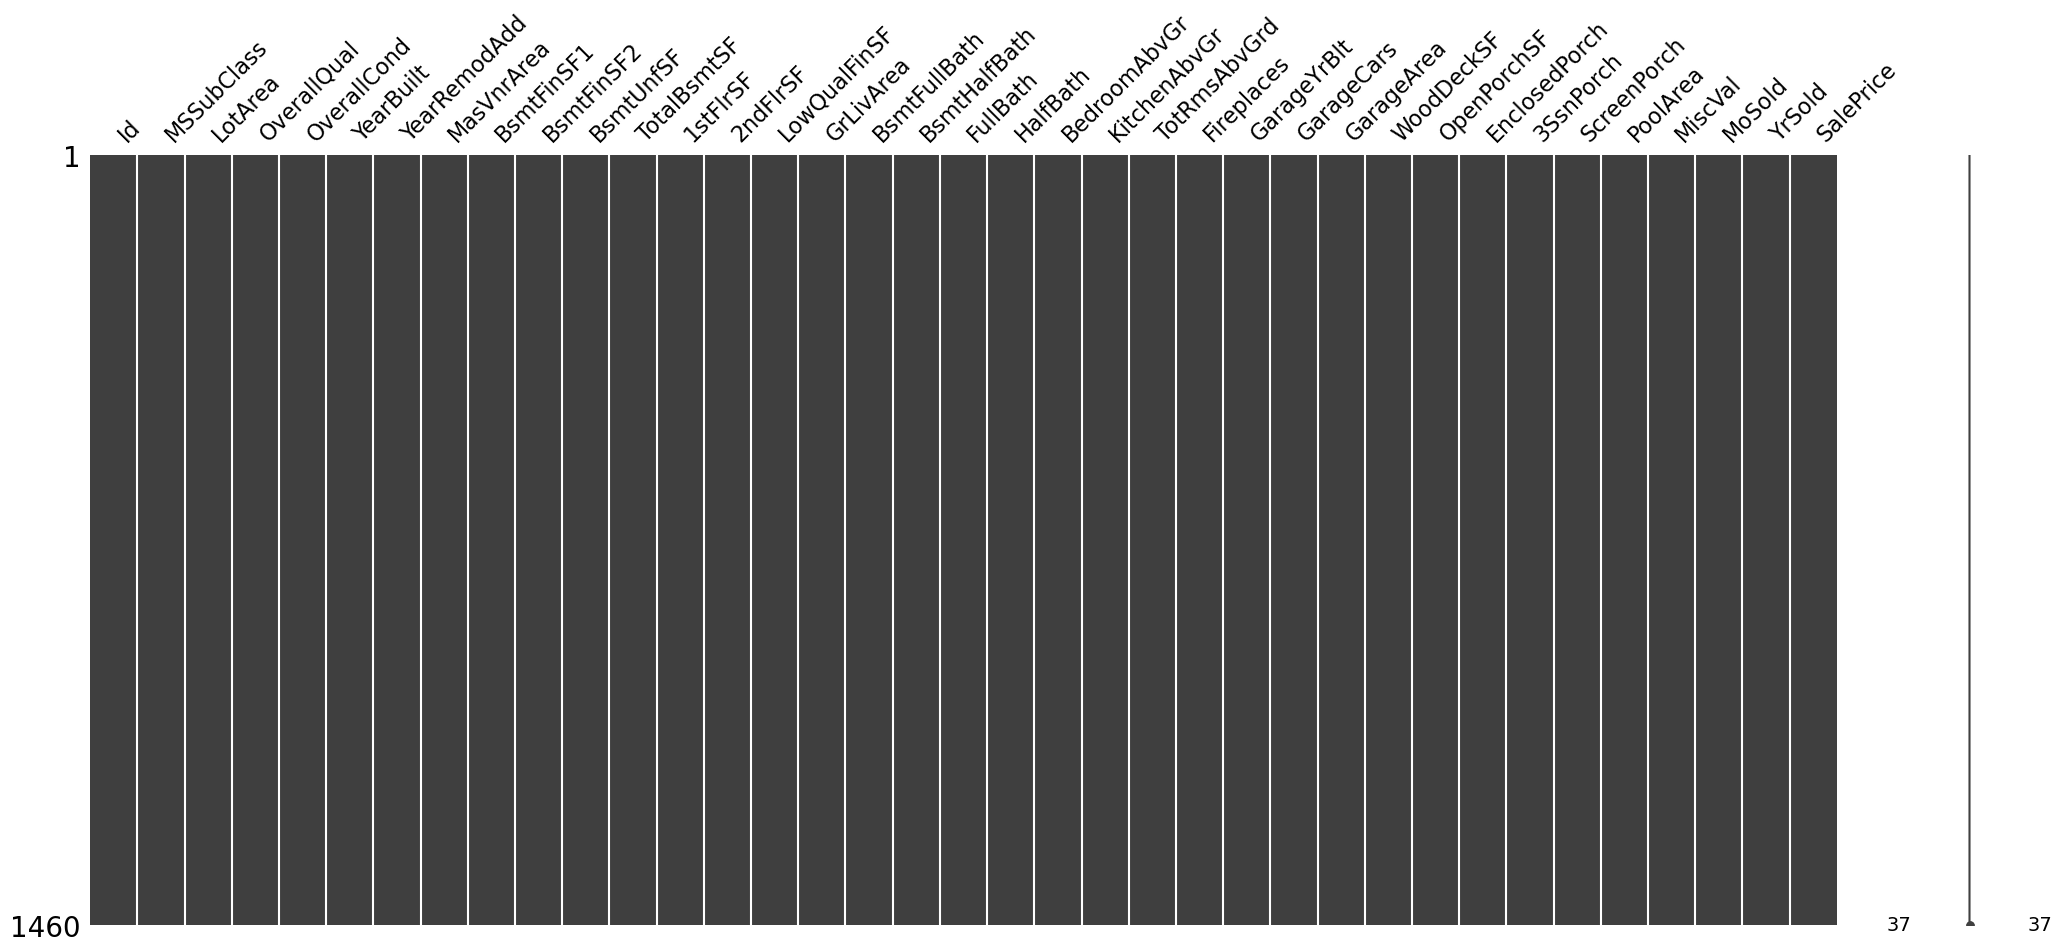

In [66]:
msno.matrix(numerical_train);

# OutLier Filtration

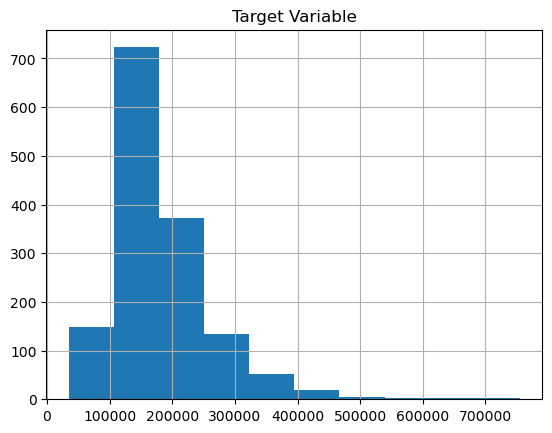

In [67]:
numerical_train["SalePrice"].hist()
plt.title("Target Variable")
plt.show()

C:\Users\nikit\AppData\Local\Temp\ipykernel_15320\3584676777.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out = pd.Series(index=df.columns)


<Axes: title={'center': 'Percentage of Outliers'}>

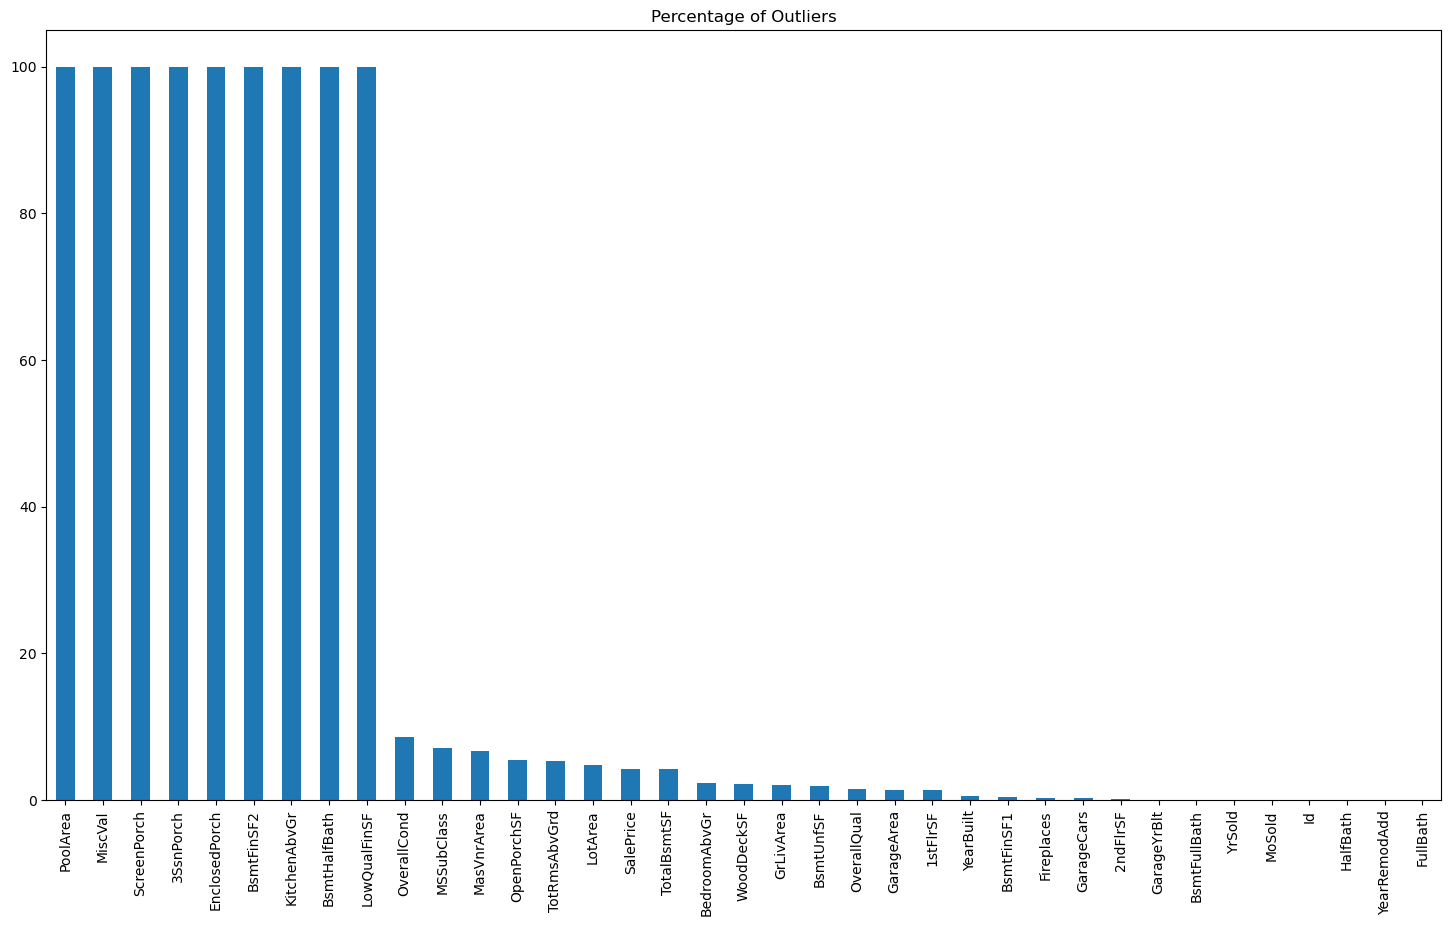

In [68]:
def count_outliers(df):
    """ Returns table feature-wise outlier count """
    out = pd.Series(index=df.columns)
    total_num = df.shape[0]
    for column in df:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lowest_val = Q1 - 1.5*IQR
        highest_val = Q3 + 1.5*IQR
        
        flter_df = df[column].copy()
        flter_df = flter_df[flter_df > lowest_val]
        flter_df = flter_df[flter_df < highest_val]

        outlier_percentage = round(100 * (total_num - flter_df.shape[0]) / total_num, 2) 
        out[column] = outlier_percentage

    return out.sort_values(ascending = False)

count_outliers(numerical_train).plot(kind="bar", figsize=(18, 10), title="Percentage of Outliers")

In [69]:
numerical_train["ScreenPorch"].describe()

count    1460.000000
mean       15.060959
std        55.757415
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       480.000000
Name: ScreenPorch, dtype: float64

In [70]:
len(numerical_train[numerical_train["ScreenPorch"] == 0]) / len(numerical_train), len(numerical_train[numerical_train["MiscVal"] == 0]) / len(numerical_train)

(0.9205479452054794, 0.9643835616438357)

There are features who have more than 90% of zeros making all other values outliers

In [71]:
too_many_outliers = count_outliers(numerical_train)
too_many_outliers = too_many_outliers[too_many_outliers > 20]
too_many_outliers

C:\Users\nikit\AppData\Local\Temp\ipykernel_15320\3584676777.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out = pd.Series(index=df.columns)


PoolArea         100.0
MiscVal          100.0
ScreenPorch      100.0
3SsnPorch        100.0
EnclosedPorch    100.0
BsmtFinSF2       100.0
KitchenAbvGr     100.0
BsmtHalfBath     100.0
LowQualFinSF     100.0
dtype: float64

In [72]:
numerical_train.drop(too_many_outliers.index, axis=1, inplace=True)
count_outliers(numerical_train)

C:\Users\nikit\AppData\Local\Temp\ipykernel_15320\3584676777.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out = pd.Series(index=df.columns)


OverallCond     8.56
MSSubClass      7.05
MasVnrArea      6.71
OpenPorchSF     5.41
TotRmsAbvGrd    5.34
LotArea         4.73
SalePrice       4.18
TotalBsmtSF     4.18
BedroomAbvGr    2.40
WoodDeckSF      2.19
GrLivArea       2.12
BsmtUnfSF       1.99
OverallQual     1.58
GarageArea      1.44
1stFlrSF        1.37
YearBuilt       0.62
BsmtFinSF1      0.48
GarageCars      0.34
Fireplaces      0.34
2ndFlrSF        0.14
BsmtFullBath    0.07
GarageYrBlt     0.07
HalfBath        0.00
FullBath        0.00
YearRemodAdd    0.00
MoSold          0.00
YrSold          0.00
Id              0.00
dtype: float64

In [73]:
import numpy as np

def drop_outliers(ddf, field_name):
    """ Drops outliers for specific column """
    df = ddf.copy()
    iqr = 1.5 * (np.percentile(df[field_name], 75) - np.percentile(df[field_name], 25))
    df.drop(df[df[field_name] > (iqr + np.percentile(df[field_name], 75))].index, inplace=True)
    df.drop(df[df[field_name] < (np.percentile(df[field_name], 25) - iqr)].index, inplace=True)
    return df

def drop_outliers_IQR(df):
    """ Drops samples that include outliers """
    for column in df:
        if df[column].dtypes != np.int64:
            continue
        df = drop_outliers(df, column)
    return df

numerical_train = drop_outliers_IQR(numerical_train)
print(numerical_train.shape)

(945, 28)


In [74]:
count_outliers(numerical_train)

C:\Users\nikit\AppData\Local\Temp\ipykernel_15320\3584676777.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out = pd.Series(index=df.columns)


MSSubClass      7.72
MasVnrArea      6.46
OpenPorchSF     2.86
LotArea         1.90
SalePrice       1.06
TotRmsAbvGrd    1.06
GrLivArea       0.63
WoodDeckSF      0.53
BsmtUnfSF       0.53
TotalBsmtSF     0.21
1stFlrSF        0.21
OverallQual     0.21
MoSold          0.00
GarageArea      0.00
YrSold          0.00
GarageCars      0.00
GarageYrBlt     0.00
Fireplaces      0.00
Id              0.00
BedroomAbvGr    0.00
HalfBath        0.00
FullBath        0.00
2ndFlrSF        0.00
BsmtFinSF1      0.00
YearRemodAdd    0.00
YearBuilt       0.00
OverallCond     0.00
BsmtFullBath    0.00
dtype: float64

Outliers were filtered. Now I must align Target (Y) to data (X)

In [75]:
numerical_train.shape

(945, 28)

In [76]:
numerical_train.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,...,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold,SalePrice
0,1,60,8450,7,5,2003,2003,196.0,706,150,...,8,0,2003.0,2,548,0,61,2,2008,208500
2,3,60,11250,7,5,2001,2002,162.0,486,434,...,6,1,2001.0,2,608,0,42,9,2008,223500
3,4,70,9550,7,5,1915,1970,0.0,216,540,...,7,1,1998.0,3,642,0,35,2,2006,140000
4,5,60,14260,8,5,2000,2000,350.0,655,490,...,9,1,2000.0,3,836,192,84,12,2008,250000
5,6,50,14115,5,5,1993,1995,0.0,732,64,...,5,0,1993.0,2,480,40,30,10,2009,143000


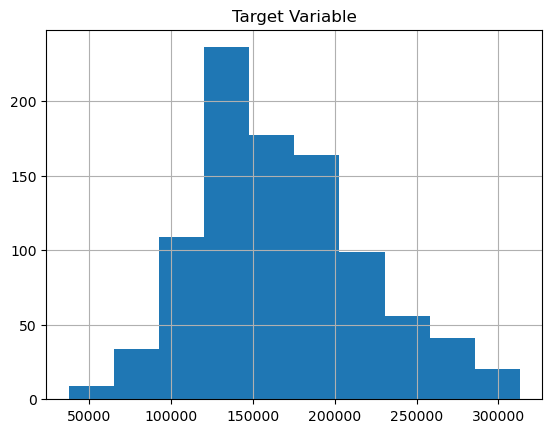

In [77]:
numerical_train["SalePrice"].hist()
plt.title("Target Variable")
plt.show()

Comparing the Target variable before and after outlier filtration it is clear that now target is more NORMALIZED which must help in regression!

# Data Separation

In [78]:
Y = numerical_train["SalePrice"]
X = numerical_train.drop(["SalePrice"], axis=1)

# Scaling

In [79]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)

X = pd.DataFrame(scaler.transform(X))

In [80]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,-1.714272,0.400948,-0.330152,0.852765,-0.638467,1.055110,0.921273,0.770256,0.741102,-1.043681,...,0.286507,1.379511,-0.938430,1.017161,0.428135,0.507259,-0.799543,0.658039,-1.573098,0.145171
1,-1.709538,0.400948,0.692843,0.852765,-0.638467,0.985243,0.873441,0.537522,0.174614,-0.350178,...,0.286507,-0.181732,0.741146,0.934111,0.428135,0.835793,-0.799543,0.206254,1.027763,0.145171
2,-1.707171,0.733751,0.071739,0.852765,-0.638467,-2.019060,-0.657206,-0.571385,-0.520622,-0.091335,...,0.286507,0.598889,0.741146,0.809535,1.926607,1.021963,-0.799543,0.039806,-1.573098,-1.354133
3,-1.704804,0.400948,1.792562,1.707339,-0.638467,0.950309,0.777775,1.824402,0.609780,-0.213431,...,1.782360,2.160132,0.741146,0.892586,1.926607,2.084225,1.075800,1.204937,2.142418,0.145171
4,-1.702437,0.068145,1.739586,-0.856382,-0.638467,0.705773,0.538612,-0.571385,0.808051,-1.253685,...,-2.705198,-0.962353,-0.938430,0.601908,0.428135,0.134919,-0.408846,-0.079084,1.399314,0.894822


In [81]:
Y

0       208500
2       223500
3       140000
4       250000
5       143000
         ...  
1451    287090
1453     84500
1454    185000
1455    175000
1458    142125
Name: SalePrice, Length: 945, dtype: int64

In [82]:
X.shape, Y.shape

((945, 27), (945,))

In [83]:
945/15

63.0

# Modeling

In [84]:
from keras.layers import Dense, Input
from keras.models import Sequential

model = Sequential()
model.add(Input(shape = (X.shape[1],), batch_size=15))
model.add(Dense(10, activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dense(50, activation="relu"))
model.add(Dense(100, activation="relu"))
model.add(Dense(50, activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(1))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (15, 10)                  280       
                                                                 
 dense_49 (Dense)            (15, 20)                  220       
                                                                 
 dense_50 (Dense)            (15, 50)                  1050      
                                                                 
 dense_51 (Dense)            (15, 100)                 5100      
                                                                 
 dense_52 (Dense)            (15, 50)                  5050      
                                                                 
 dense_53 (Dense)            (15, 20)                  1020      
                                                                 
 dense_54 (Dense)            (15, 10)                 

In [85]:
model.compile(loss='mean_absolute_error', optimizer="adam")
history = model.fit(x=X, y=Y, batch_size=14, epochs=100, validation_split=0.2)

Epoch 1/100
54/54 [==============================] - 1s 7ms/step - loss: 167476.9062 - val_loss: 155143.5625
Epoch 2/100
54/54 [==============================] - 0s 2ms/step - loss: 161671.4219 - val_loss: 133539.6406
Epoch 3/100
54/54 [==============================] - 0s 3ms/step - loss: 65304.8633 - val_loss: 42797.8984
Epoch 4/100
54/54 [==============================] - 0s 3ms/step - loss: 34111.0078 - val_loss: 32750.0020
Epoch 5/100
54/54 [==============================] - 0s 3ms/step - loss: 29394.2695 - val_loss: 36261.9062
Epoch 6/100
54/54 [==============================] - 0s 3ms/step - loss: 26288.6289 - val_loss: 26387.7168
Epoch 7/100
54/54 [==============================] - 0s 2ms/step - loss: 24159.0527 - val_loss: 26491.1914
Epoch 8/100
54/54 [==============================] - 0s 3ms/step - loss: 22724.6543 - val_loss: 22831.2598
Epoch 9/100
54/54 [==============================] - 0s 2ms/step - loss: 21605.5508 - val_loss: 23182.1777
Epoch 10/100
54/54 [=============

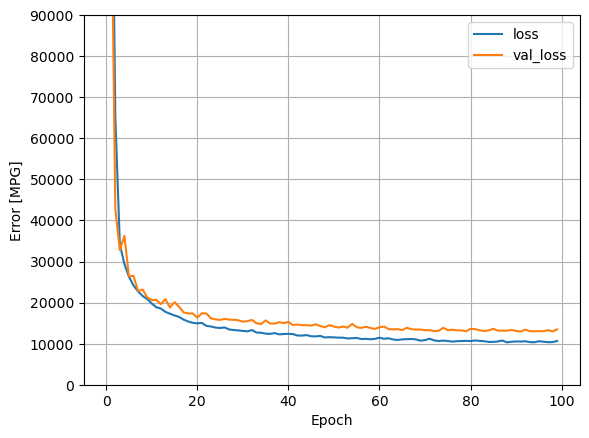

In [86]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 90000])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.legend()
plt.grid(True)

Out of first 4 BaseLines this one is The Best on performance

So far, numerical approach + Outlier filtration showed the best performance in 14,000 

However, due to less samples this number could not be directly compared to others. Therefore, I will do actual submissions with test data to have objectve measure of baselines!

# Submission

In [87]:
test = pd.read_csv("./dataset/test.csv")
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [88]:
test = test.select_dtypes(exclude="object")
test.shape

(1459, 37)

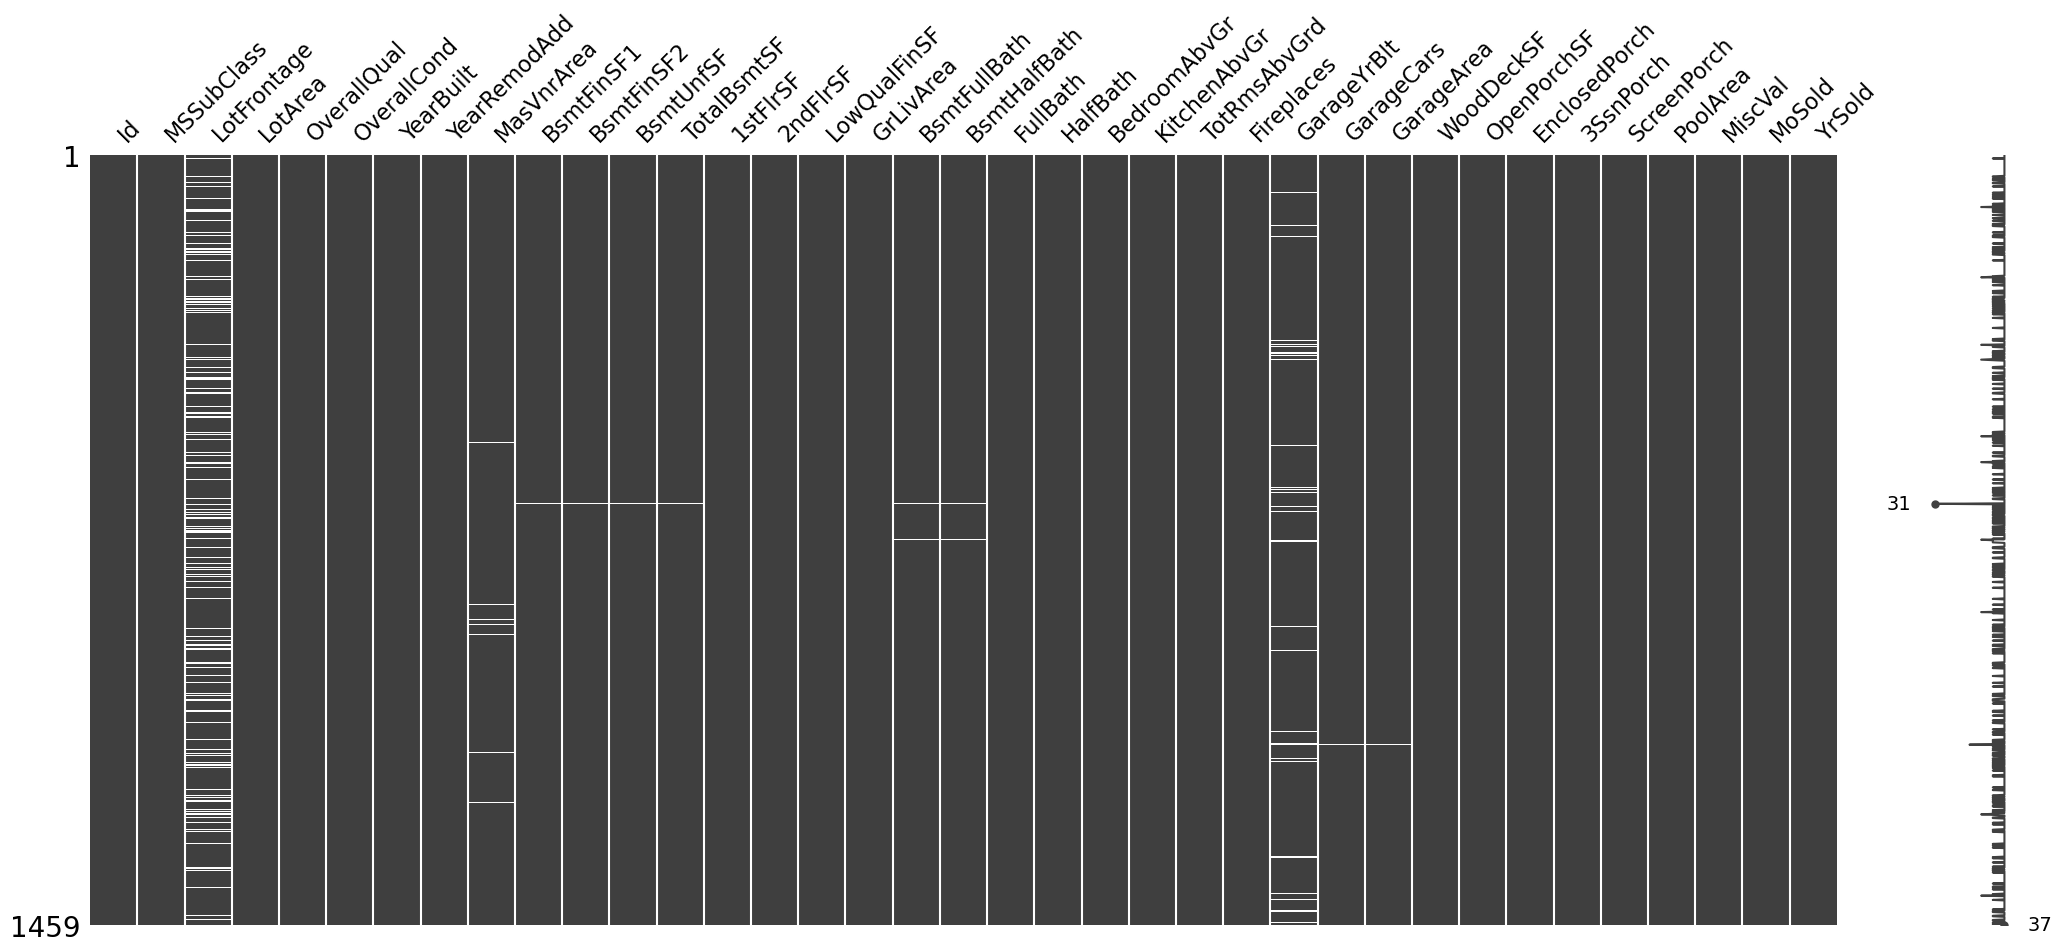

In [89]:
msno.matrix(test);

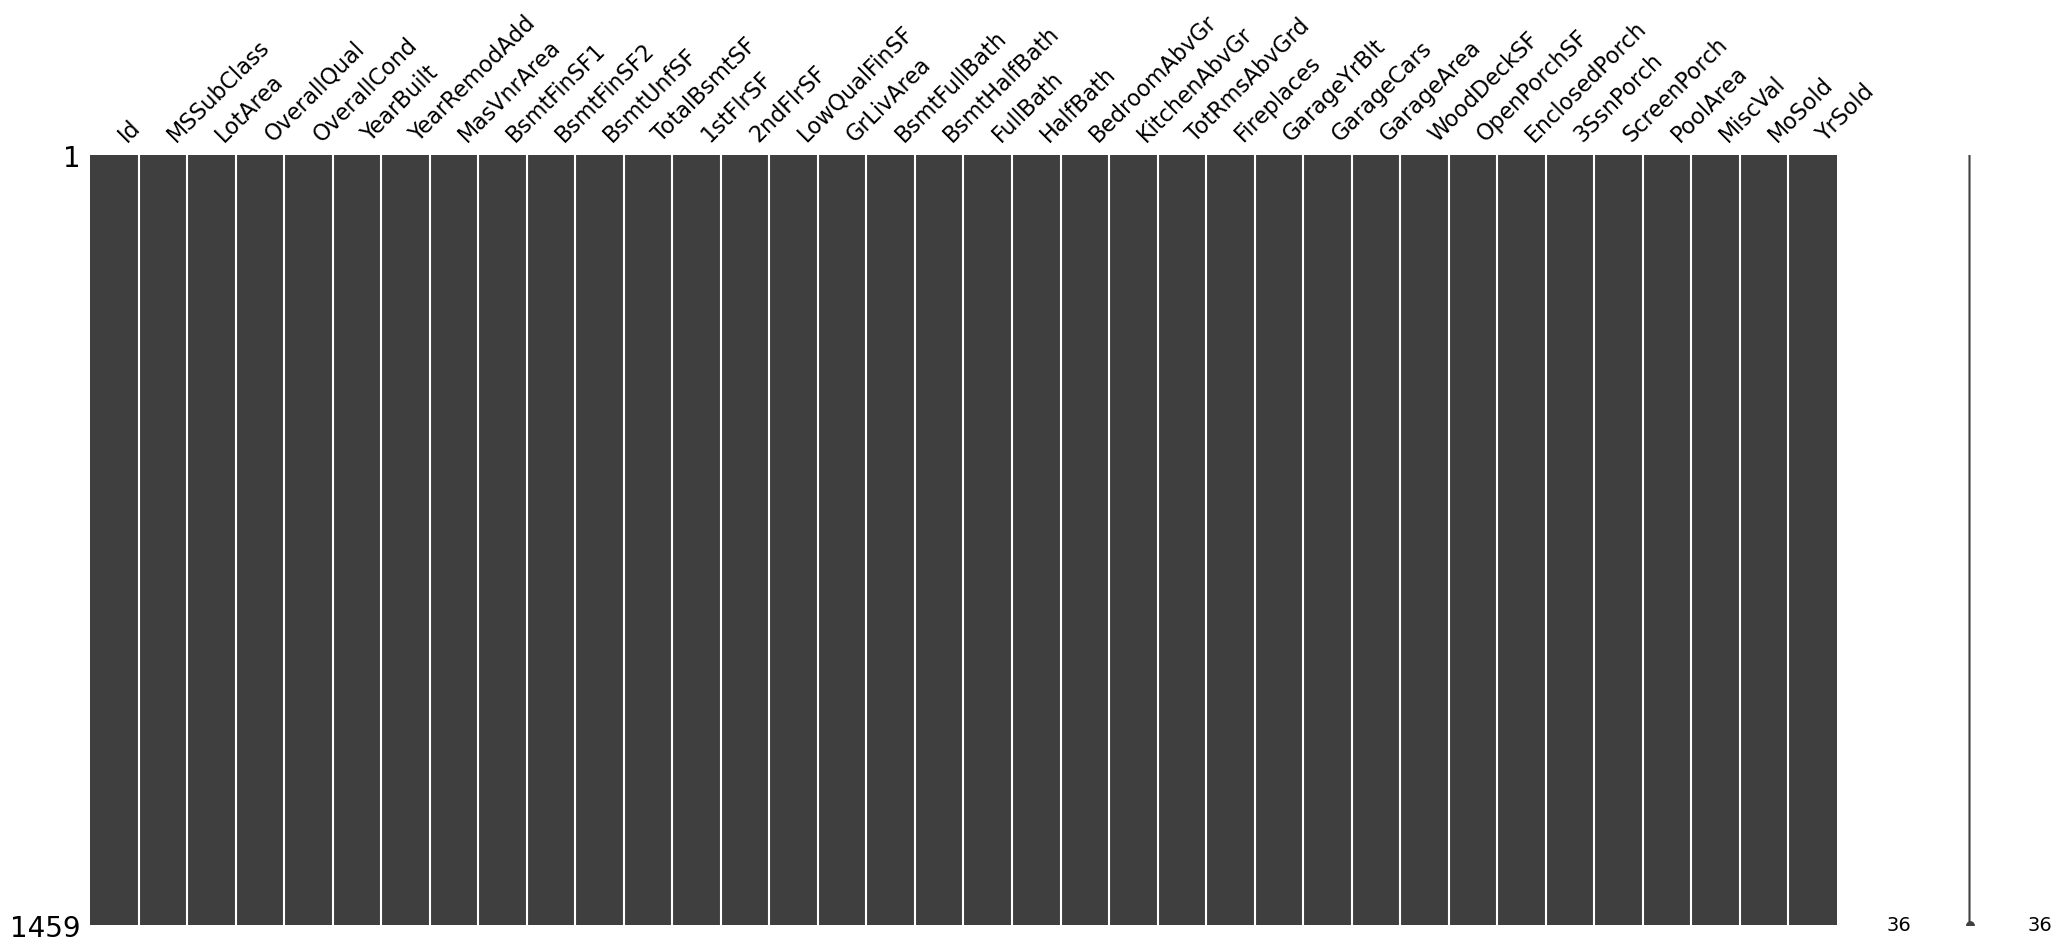

In [90]:
test.drop(["LotFrontage"], axis=1, inplace=True)
test.fillna(means_to_fill, inplace = True)   ## PS: I must use statistical values from training set only!
msno.matrix(test);

In terms of OutLier filtration I cannot remove bad samples, but I must remove features I dropped in Training set to ensure same dimentionality for NN model

In [91]:
test.drop(too_many_outliers.index, axis=1, inplace=True)
count_outliers(test)

C:\Users\nikit\AppData\Local\Temp\ipykernel_15320\3584676777.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out = pd.Series(index=df.columns)


OverallCond     8.70
MasVnrArea      7.20
MSSubClass      7.13
OpenPorchSF     5.62
TotalBsmtSF     4.18
LotArea         4.11
TotRmsAbvGrd    3.70
GrLivArea       3.02
BedroomAbvGr    2.95
WoodDeckSF      2.40
BsmtUnfSF       1.78
OverallQual     1.71
1stFlrSF        1.58
GarageArea      1.51
GarageCars      0.82
BsmtFinSF1      0.55
Fireplaces      0.48
2ndFlrSF        0.34
FullBath        0.27
GarageYrBlt     0.21
YearBuilt       0.14
BsmtFullBath    0.07
MoSold          0.00
Id              0.00
HalfBath        0.00
YearRemodAdd    0.00
YrSold          0.00
dtype: float64

In [92]:
X_test = pd.DataFrame(scaler.transform(test))
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,1.741584,-0.930264,0.828755,-0.856382,0.608127,-0.412107,-1.087701,-0.571385,0.128265,-0.750651,...,-1.209345,-0.962353,-0.938430,-0.726901,-1.070337,1.503814,0.567895,-0.792429,-0.086892,1.644474
1,1.743951,-0.930264,1.795120,-0.001809,0.608127,-0.516909,-1.231199,0.167887,1.299866,-0.418551,...,0.286507,-0.181732,-0.938430,-0.851477,-1.070337,-0.784978,3.039050,0.063585,-0.086892,1.644474
2,1.746318,0.400948,1.635460,-0.856382,-0.638467,0.845508,0.682110,-0.571385,0.959973,-1.075425,...,0.286507,-0.181732,0.741146,0.768010,0.428135,0.145871,1.271148,0.016028,-1.201547,1.644474
3,1.748685,0.400948,0.228111,-0.001809,0.608127,0.880442,0.682110,-0.434482,0.473308,-0.618788,...,0.286507,0.598889,0.741146,0.809535,0.428135,0.080164,2.716725,0.063585,-0.086892,1.644474
4,1.751052,2.397766,-1.588801,1.707339,-0.638467,0.670839,0.395113,-0.571385,-0.399599,1.073456,...,-1.209345,-0.962353,-0.938430,0.560383,0.428135,0.277284,-0.799543,1.157380,-1.944650,1.644474


In [93]:
X_test.shape

(1459, 27)

In [104]:
y_predict = model.predict(X_test)[:, 0]
y_predict, y_predict.shape

46/46 [==============================] - 0s 4ms/step


(array([112227.414, 150934.31 , 189231.94 , ..., 230708.05 , 103273.81 ,
        262454.28 ], dtype=float32),
 (1459,))

In [105]:
my_submission = pd.DataFrame({'Id': test.Id, 'SalePrice': y_predict})
my_submission.to_csv('submission.csv', index=False)

Final Score: 0.20760